Jeremy Howard's 8 steps for tackling an image recognition problem.

Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Verify GPU

In [3]:
torch.cuda.set_device(0)

In [4]:
torch.cuda.is_available()

True

Set network size and architecture

In [7]:
#sz = 224
sz = 224
#arch = resnet34
arch = resnext50
bs = 64

Split off cross validation set

In [8]:
PATH = "data/dogbreed/"
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

Helper functions

In [10]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time


#### 1) Enable data augmentation, and precompute=True

In [12]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)


100%|██████████| 162/162 [01:53<00:00,  1.39it/s]


#### 2) Use lr_find() to find highest learning rate where loss is still clearly improving

In [13]:
lrf=learn.lr_find()

 92%|█████████▏| 118/128 [00:02<00:00, 39.33it/s, loss=4.2] 


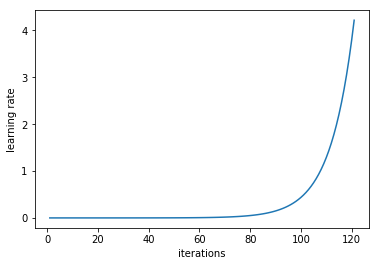

In [14]:
learn.sched.plot_lr()

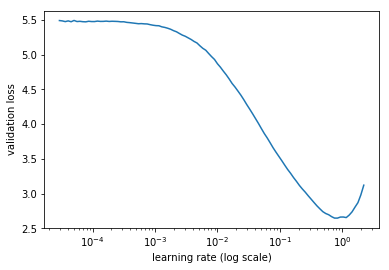

In [15]:
learn.sched.plot()

In [16]:
lr = 1e-1

#### 3) Train last layer from precomputed activations for 1-2 epochs

In [17]:
learn.fit(lr, 5)

epoch      trn_loss   val_loss   accuracy                    
    0      0.803416   0.456381   0.872798  
    1      0.481329   0.399798   0.881115                    
    2      0.323071   0.394253   0.882094                    
    3      0.248515   0.41054    0.892857                    
    4      0.186678   0.425721   0.886497                    



[0.42572091414853785, 0.886497065978974]

Add dropout

In [18]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)
learn.fit(lr, 5)

epoch      trn_loss   val_loss   accuracy                    
    0      0.852208   0.454217   0.868885  
    1      0.516428   0.41875    0.883562                    
    2      0.389251   0.41336    0.881115                    
    3      0.304518   0.390068   0.887476                    
    4      0.268643   0.410434   0.886008                    



[0.4104344274724766, 0.8860078300048694]

#### 4) Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1

In [19]:
learn.precompute=False
learn.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.321525   0.348542   0.898239  
    1      0.315774   0.344281   0.906067                    
    2      0.282984   0.353731   0.90411                     
    3      0.289087   0.352392   0.900685                    
    4      0.281853   0.355758   0.900196                    



[0.35575771556325153, 0.9001956956493878]

#### Increase image size

In [20]:
learn.set_data(get_data(299, bs))
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.287231   0.315807   0.914873  
    1      0.265466   0.320713   0.909491                    
    2      0.235907   0.318519   0.906067                    



[0.3185185010302557, 0.9060665371366676]

#### 5) Unfreeze all layers

In [15]:
learn.unfreeze()

#### 6) Set earlier layers to 3x-10x lower learning rate than next higher layer

In [16]:
lr=np.array([1e-3,1e-2,1e-1])

#### 7) Use lr_find() again

In [17]:
lrf=learn.lr_find()

 70%|██████▉   | 89/128 [01:20<00:35,  1.11it/s, loss=2.7]  

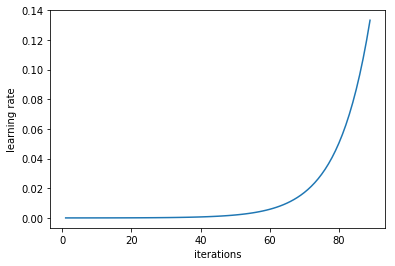

In [18]:
learn.sched.plot_lr()

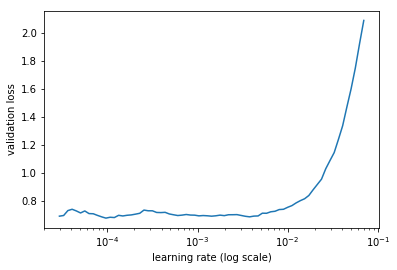

In [19]:
learn.sched.plot()

#### 8) Train full network with cycle_mult=2 until over-fitting

In [23]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.170643   0.324704   0.91047   
    1      0.182192   0.34504    0.905577                    
    2      0.153281   0.322755   0.910959                    
    3      0.18171    0.334727   0.907534                    
    4      0.174997   0.33118    0.914873                    
    5      0.147675   0.327426   0.910959                    
    6      0.126647   0.319366   0.913894                    



[0.31936568469392346, 0.9138943270694486]

#### Add test time augmentation

In [24]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9207436399217221